In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iminuit
from iminuit import Minuit, cost
from numba_stats import norm, truncexpon, crystalball, expon
from scipy.optimize import curve_fit
import mplhep as hep
hep.style.use("LHCb2")

np.random.seed(42)

#read the data from the csv file
data = np.genfromtxt('/home/aavash/Downloads/data_from_lab/filtered_by_type/inv_mass_filtered_all_Bminus.csv', delimiter=',')
data_plus = np.genfromtxt('/home/aavash/Downloads/data_from_lab/filtered_by_type/inv_mass_filtered_all_Bplus.csv', delimiter=',')

In [127]:
BINS = 100

BINS = 150


In [128]:
def get_unc(bin_heights):
    return np.sqrt(bin_heights)

In [129]:
from numba import jit
@jit
def signal(x, mu, sigma, n):
    return n * norm.cdf(x, mu, sigma)

from scipy.stats import halfnorm
def combinatorial(x, mu, sigma, n):
    result = n * halfnorm.cdf(x, mu, sigma)
    # result = np.zeros(len(x))
    # result = np.where(x > 5100, n * norm.cdf(x, mu, sigma), 0)
    return result
@jit
def background(x, tau, xoffset, norm):
    result = norm * expon.cdf(x, xoffset, tau)
    return result
    #return norm * truncexpon.cdf(x, x[0], x[-1], xoffset, tau)

@jit
def cdf(x, norm_mu, norm_sigma, norm_n,
        comb_mu, comb_sigma, comb_n,
        tau, xoffset, norm,
        total_norm):
    
    signal_result = signal(x, norm_mu, norm_sigma, norm_n)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

@jit
def crystal_signal(x, beta, m, loc, scale, n):
    return n * crystalball.cdf(x, beta, m, loc, scale)
@jit
def cdf_crystal(x,
                crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm,
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, norm,
                total_norm):
    
    signal_result = crystal_signal(x, crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

def fit_crystal(x, beta, m , loc, scale, c_norm, 
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, exp_norm, total_norm
                ):
    crystal_val = crystalball.pdf(x, beta, m, loc, scale) * c_norm
    comb_val = norm.pdf(x, comb_mu, comb_sigma) * comb_n
    exp_val = expon.pdf(x, tau, xoffset) * exp_norm
    return (crystal_val + comb_val + exp_val) * total_norm
def fit_curve_post_minut(data, p0_vals):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals)
    plt.clf()

    return popt, pcov

In [130]:
data_plus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/from_todor/inv_mass_filtered_Bplus .csv", delimiter=",")

#take only data from 5100 to 5400
data_plus = data_plus[(data_plus > 5100) & (data_plus < 5600)]
n_plus, xe_plus = np.histogram(data_plus, bins=BINS)
c_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus, cdf_crystal)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [131]:
n_plus_c = Minuit(     c_crystal_plus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_plus_c.limits['crystal_m'] = (0, 20)
n_plus_c.limits['crystal_scale'] = (1, 100)
n_plus_c.limits['crystal_norm'] = (1, 1e4)
n_plus_c.limits['crystal_loc'] = (5200, 5400)

n_plus_c.limits['comb_mu'] = (5100, 5101)
n_plus_c.limits['comb_sigma'] = (1, 50)
n_plus_c.limits['comb_n'] = (1, 1e4)

n_plus_c.fixed["crystal_beta"] = True
n_plus_c.fixed["comb_mu"] = True


In [132]:
n_plus_c.migrad(iterate=20, ncall=300000).migrad()
n_plus_c.interactive()

/tmp/ipykernel_6403/788870761.py:32: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cdf_crystal" failed type inference due to: Untyped global name 'combinatorial': Cannot determine Numba type of <class 'function'>

File "../../../../tmp/ipykernel_6403/788870761.py", line 40:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cdf_crystal" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_6403/788870761.py", line 32:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthedocs.io/

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 168.8 (χ²/ndof = 1.2)      │             Nfcn = 2648              │
│ EDM = 2.61e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │   1.200   │   0.012   │            │            │         │         │  yes  │
│ 1 │ crystal_m     │    3.1    │    0.6    │            │            │    0    │   20    │       │
│ 2 │ crystal_loc   │ 5.28387e3 │ 0.00027e3 │            │            │  5200   │  5400   │       │
│ 3 │ crystal_scale │   20.68   │   0.28    │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │    326    │    17     │            │            │    1    │  10000  │       │
│ 5 │ comb_mu       │  5.10e3   │  0.05e3   │            │            │  5100   │  5101   │  yes  │
│ 6 │ comb_sigma    │   39.8    │    1.4    │            │            │    1    │   50    │       │
│ 7 │ comb_n        │    101    │     6     │            │            │    1    │  10000  │       │
│ 8 │ tau           │  1.80e3   │  0.06e3   │            │            │         │         │       │
│ 9 │ xoffset       │  6.86e3   │  0.12e3   │            │            │         │         │       │
│ 10│ norm          │  1.35e3   │  0.09e3   │            │            │         │         │       │
│ 11│ total_norm    │   56.8    │    2.8    │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │  crystal_beta     crystal_m   crystal_loc crystal_scale  crystal_norm       comb_mu    comb_sigma        comb_n           tau       xoffset          norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  crystal_beta │             0           0.0          0.00          0.00             0             0           0.0             0           0e3             0           0e3             0 │
│     crystal_m │           0.0         0.392         -0.04          0.05          -3.2           0.0           0.6           1.6          -6.9          -3.6          -2.7          -0.1 │
│   crystal_loc │          0.00         -0.04        0.0723         -0.02          0.31          0.00         -0.05         -0.14         -0.21         -0.24         -0.18          0.00 │
│ crystal_scale │          0.00          0.05         -0.02        0.0801         -0.06          0.00          0.06          0.20          2.03          1.10          0.82          0.02 │
│  crystal_norm │             0          -3.2          0.31         -0.06           278             0          -5.2            60       -0.12e3        0.53e3        0.40e3 

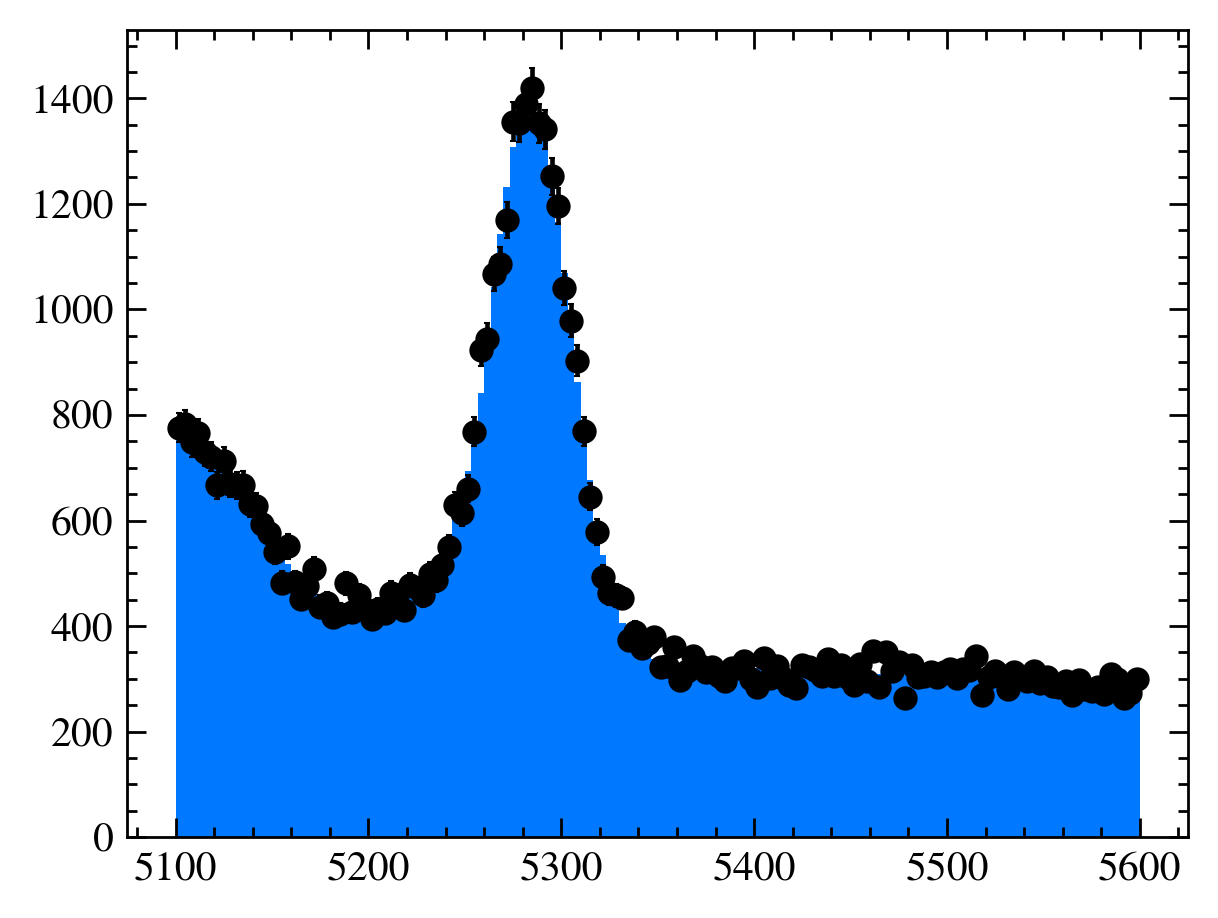

In [133]:
n_plus_c.hesse()

In [134]:
n_plus_c.nfit

10

In [135]:
n_plus_c.ndof

140.0

Therefore here, using 100 bins, we have 
dof of = 100 - 10 = 90

with a chi-squared value of 90.0 


In [137]:
array_p0_crystal =  np.array(  [    1.2, 3.066800708293673, 5283.866200116772,
                                    20.679652920238063,160.86015229246274,
                                    5100, 50, 49.60, 80.5, 5000.5,
                                    1459, 114.939])

#extract 

epsilon = 200
upper_crystal = array_p0_crystal + epsilon
lower_crystal = array_p0_crystal - epsilon

#free the normalisation parameters in the array_p0_crystal using index
lower_crystal[0] = array_p0_crystal[0] - 1e-1
upper_crystal[0] = array_p0_crystal[0] + 1e-1

upper_crystal[1] = array_p0_crystal[1] + 1e-1
lower_crystal[1] = array_p0_crystal[1] - 1e-1


upper_crystal[4] = 1e8
lower_crystal[4] = 1e-8

upper_crystal[5] = 5101
lower_crystal[5] = 5099

upper_crystal[7] = 1e8
lower_crystal[7] = 1e-8

upper_crystal[8] = 1e8
lower_crystal[8] = 1e-8

upper_crystal[9] = 1e8
lower_crystal[9] = 1e-8

upper_crystal[10] = 1e8
lower_crystal[10] = 1e-8

In [138]:
def fit_curve_post_minut_bounded(data, p0_vals, upper, lower):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    unc_vals = np.sqrt(bin_heihgts)

    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals,
                            bounds=(lower, upper), sigma=unc_vals,
                              absolute_sigma=True)
    plt.clf()
    return popt, pcov

# Using this sub to curve_fit

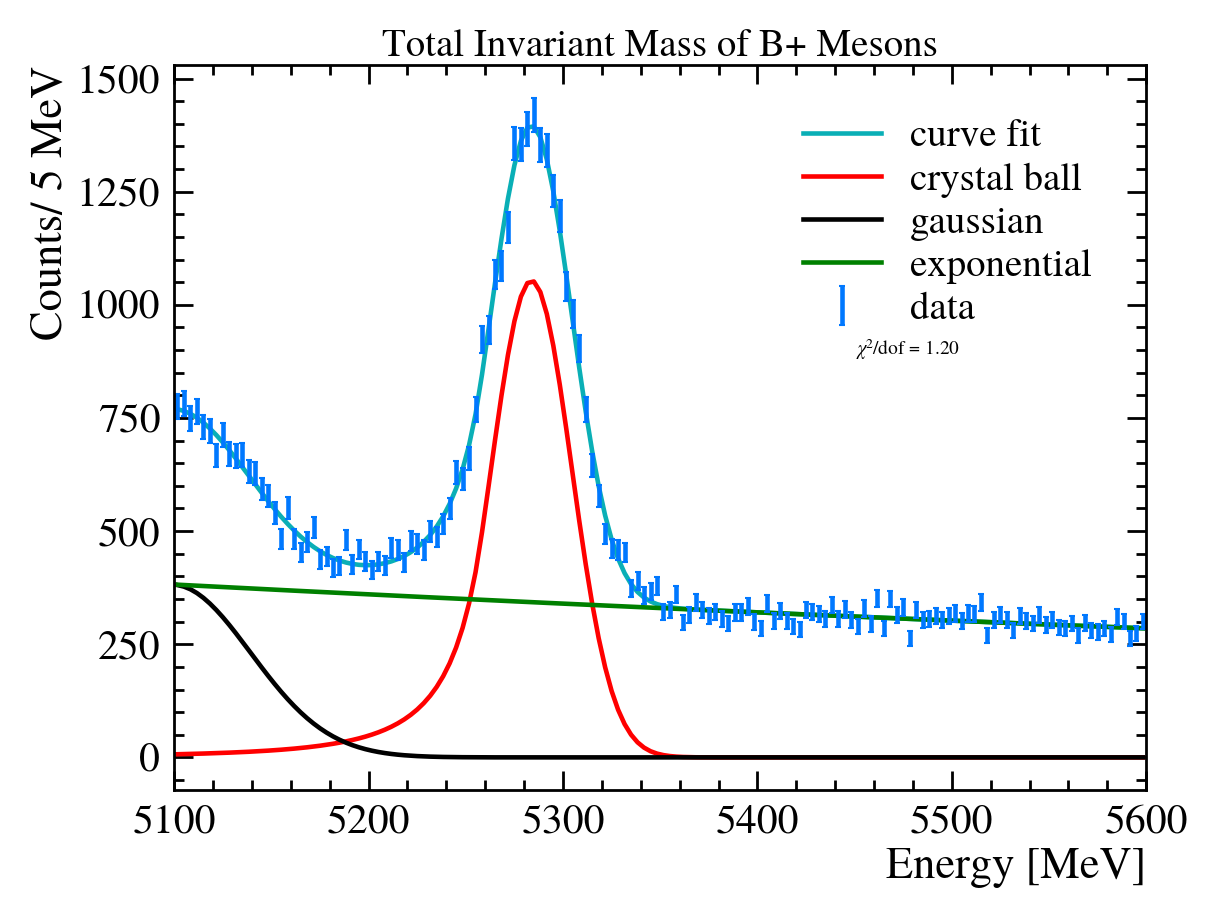

In [146]:


popt, pcov = fit_curve_post_minut_bounded(data_plus, array_p0_crystal, upper_crystal, lower_crystal)
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
plt.clf()
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

total_part = crystal_part + comb_part + exp_part

#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#plot data with error bars
#plt.scatter(bin_centers, bin_heights)
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights),
              label="data", color="C0",ls="None")
#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B+ Mesons")
plt.xlim(5100, 5600)

#add l
plt.legend()

1.1964514195836802 167.5031987417152 140


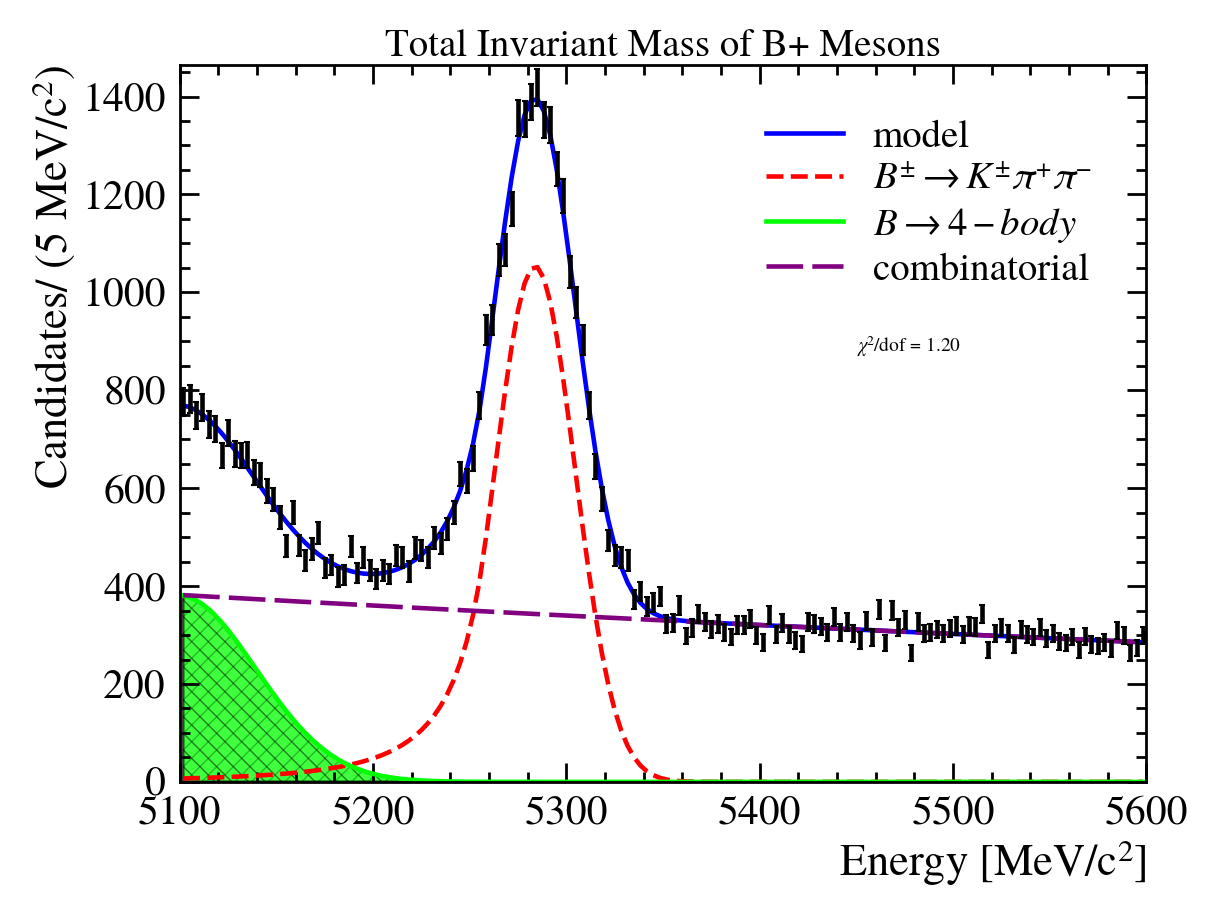

In [145]:
#plot the fit



plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="model", color="blue")
plt.plot(bin_centers, crystal_part, label=r"$B^{\pm} \rightarrow K^{\pm}\pi^{+}\pi^{-}$", color="red", 
         ls="dashed")
plt.plot(bin_centers, comb_part, label=r"$B \rightarrow 4-body$", color="lime")
plt.plot(bin_centers, exp_part, label="combinatorial", dashes=[8,2], color="purple")
plt.fill_between(bin_centers, 0, comb_part, where=comb_part > 0, hatch="//", alpha=0.5, color='lime',
                 edgecolor="black")
plt.fill_between(bin_centers, 0, comb_part, where=comb_part > 0, hatch="\\\\", alpha=0.5, color='lime',
                 edgecolor="black")


#limit view to y > 0
plt.ylim(bottom=0)
#plot data with error bars
#plt.scatter(bin_centers, bin_heights)
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights),
              color="black",ls="None")
#add labels 
plt.xlabel("Energy [MeV/c$^2$]")
plt.ylabel("Candidates/ (5 MeV/c$^2$)")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

print(reduced_chi_squared, chi_squared, dof)
#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B+ Mesons")
plt.xlim(5100, 5600)

plt.legend()

(5100.0, 5600.0)

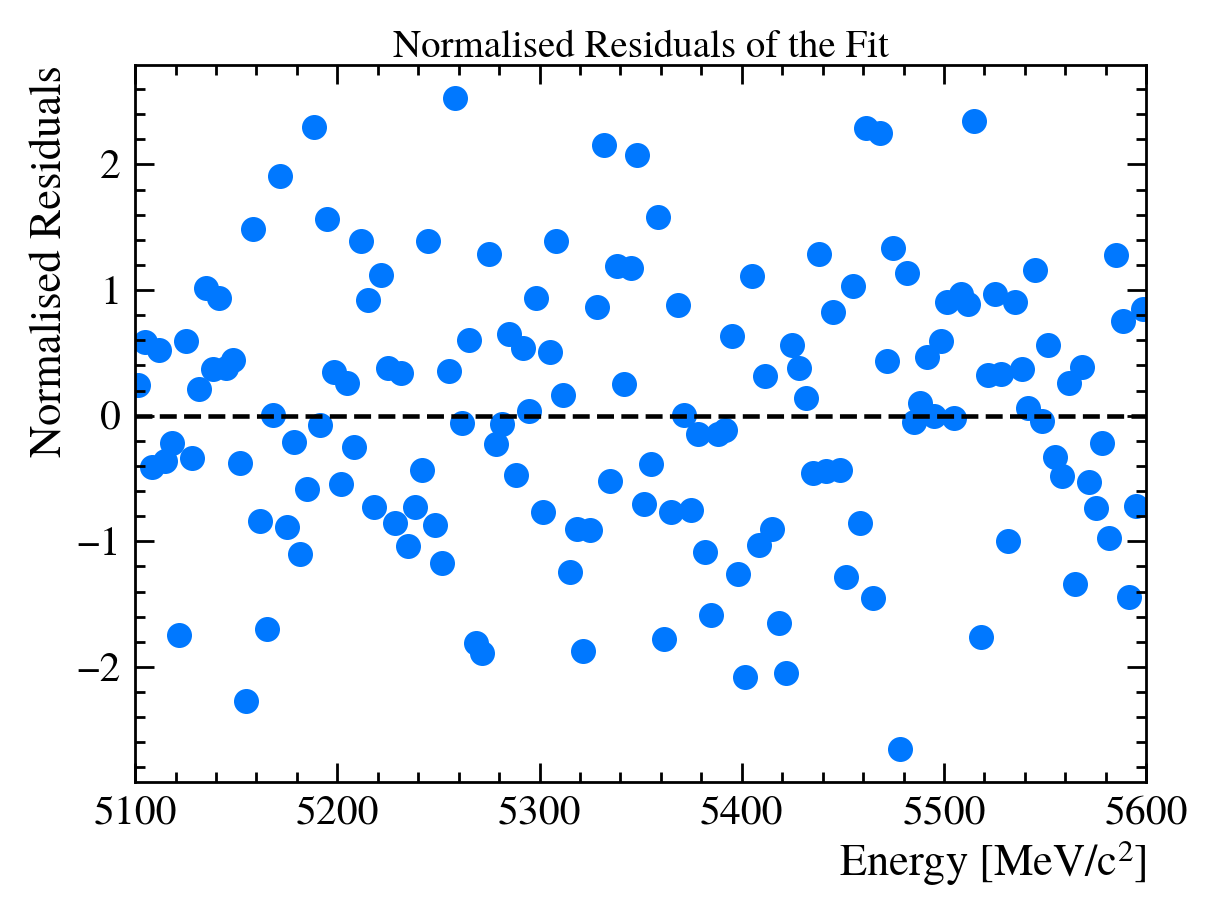

In [147]:
#plot the normalised residuals of the fit
plt.scatter(bin_centers, (bin_heights - fit_crystal(bin_centers, *popt)) / np.sqrt(bin_heights))
plt.axhline(0, color="black", ls="dashed")
plt.xlabel("Energy [MeV/c$^2$]")
plt.ylabel("Normalised Residuals")
plt.title("Normalised Residuals of the Fit")
plt.xlim(5100, 5600)



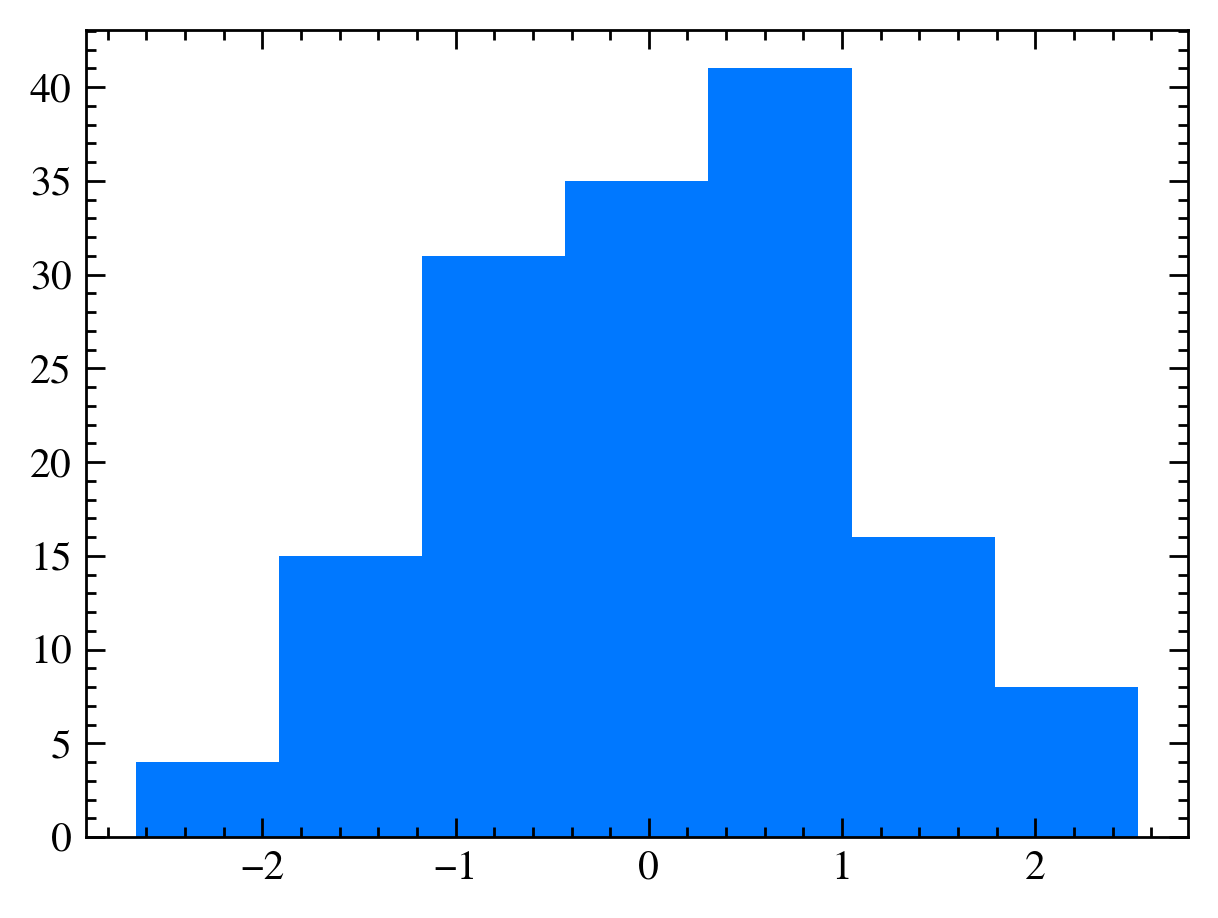

In [142]:
#plot the binned residualls
residuals, bin_edges, _ = plt.hist((bin_heights - fit_crystal(bin_centers, *popt)) / np.sqrt(bin_heights), bins=7, label="residuals")


In [148]:
#print popt with the name of the parameter
for i, name in enumerate(["crystal_beta", "crystal_m", "crystal_loc", "crystal_scale", "crystal_norm",
                            "comb_mu", "comb_sigma", "comb_n", "tau", "xoffset", "norm", "total_norm"]):
        print(name, popt[i])
    

crystal_beta 1.2521253352546307
crystal_m 2.966800708293673
crystal_loc 5283.7700789943965
crystal_scale 20.76484657958483
crystal_norm 1088.4827436210096
comb_mu 5099.000000000001
comb_sigma 40.27706218255225
comb_n 686.394673925647
tau 5291.590017644242
xoffset 1707.8794558764746
norm 10388.988779114075
total_norm 56.12782014814228


Number of events:  60369.711287108075


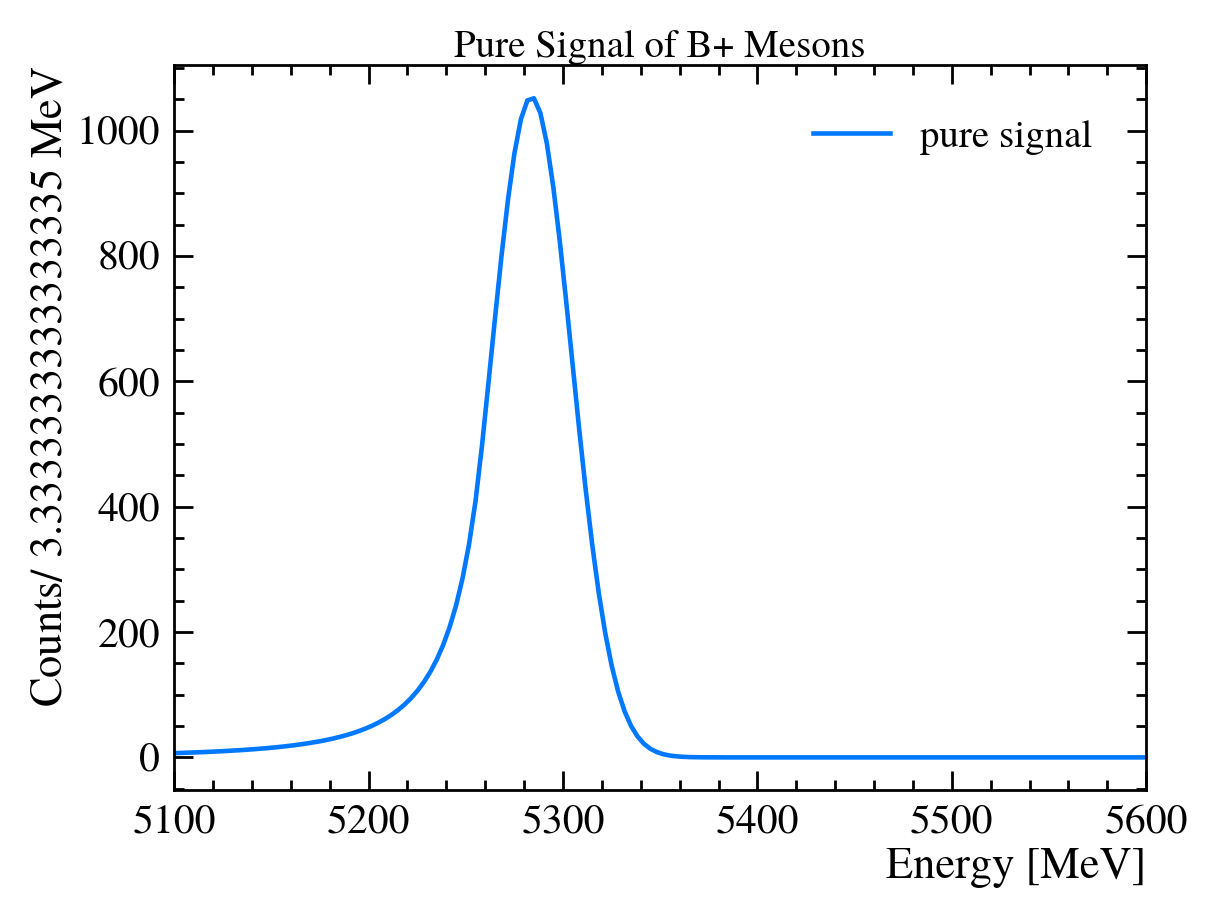

In [149]:
#subtract the background from the data
pure_signal = total_part - comb_part - exp_part

#plot the pure signal
plt.figure()
plt.plot(bin_centers, pure_signal, label="pure signal")
plt.xlabel("Energy [MeV]")
plt.ylabel(f"Counts/ ${500/BINS}$ MeV")
plt.title("Pure Signal of B+ Mesons")
plt.xlim(5100, 5600)
plt.legend()

#integrate the pure signal to get the number of events
number_of_events = np.trapz(pure_signal, bin_centers)
print("Number of events: ", number_of_events)


# Testing Different signal functions

In [150]:

def fit_gaussian(x, signal_mu, signal_sigma, signal_norm,
                partial_mu, partial_sigma, partial_norm,
                tau, xoffset, exp_norm, 
                total_norm):
    
    signal_gaussian = norm.pdf(x, signal_mu, signal_sigma) * signal_norm
    partial_gaussian = halfnorm.pdf(x, partial_mu, partial_sigma) * partial_norm
    exponential = expon.pdf(x, tau, xoffset) * exp_norm
    
    return (signal_gaussian + partial_gaussian + exponential) * total_norm

@jit
def minuit_gaussian(x, signal_mu, signal_sigma, signal_norm,
                    partial_mu, partial_sigma, partial_norm,
                    tau, xoffset, exp_norm,
                    total_norm):
    
    signal_gaussian = norm.cdf(x, signal_mu, signal_sigma) * signal_norm
    partial_gaussian = halfnorm.cdf(x, partial_mu, partial_sigma) * partial_norm
    exponential = expon.cdf(x, tau, xoffset) * exp_norm

    return (signal_gaussian + partial_gaussian + exponential) * total_norm

def fit_gaussian_post_minut(data, p0_vals):
    hist_raw = plt.hist(data, bins=100, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA
    
    pot, pcov = curve_fit(fit_gaussian, bin_centers, bin_heights, p0=p0_vals)
    plt.clf()
    return pot, pcov

In [151]:
c_crystal_signal = cost.ExtendedBinnedNLL(n_plus, xe_plus, minuit_gaussian)


/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [152]:
n_plus_gaussian_signal = Minuit(     c_crystal_signal,
                signal_mu=5100,
                signal_sigma=10,
                signal_norm=100,

                partial_mu=5100,
                partial_sigma=10,
                partial_norm=100,

                tau=1500,
                xoffset=4100,
                exp_norm=1e3,

                total_norm=1e2)
n_plus_gaussian_signal.limits['signal_sigma'] = (1, 50)
n_plus_gaussian_signal.limits['signal_norm'] = (1, 1e4)
n_plus_gaussian_signal.limits['signal_mu'] = (5200, 5400)

n_plus_gaussian_signal.limits['partial_sigma'] = (1, 50)
n_plus_gaussian_signal.limits['partial_norm'] = (1, 1e4)
n_plus_gaussian_signal.limits['partial_mu'] = (5100, 5101)

n_plus_gaussian_signal.limits['tau'] = (1, 1e4)

n_plus_gaussian_signal.fixed["partial_mu"] = True

In [153]:
n_plus_gaussian_signal.migrad(iterate=20, ncall=300000).migrad()
n_plus_gaussian_signal.interactive()

/tmp/ipykernel_6403/3072039654.py:12: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "minuit_gaussian" failed type inference due to: Untyped global name 'halfnorm': Cannot determine Numba type of <class 'scipy.stats._continuous_distns.halfnorm_gen'>

File "../../../../tmp/ipykernel_6403/3072039654.py", line 19:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "minuit_gaussian" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_6403/3072039654.py", line 12:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more inform

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 166.1 (χ²/ndof = 1.8)      │             Nfcn = 1106              │
│ EDM = 8.2e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ signal_mu     │ 5.28331e3 │ 0.00026e3 │            │            │  5200   │  5400   │       │
│ 1 │ signal_sigma  │   20.69   │   0.27    │            │            │    1    │   50    │       │
│ 2 │ signal_norm   │    175    │     8     │            │            │    1    │  10000  │       │
│ 3 │ partial_mu    │  5.10e3   │  0.05e3   │            │            │  5100   │  5101   │  yes  │
│ 4 │ partial_sigma │   36.2    │    1.6    │            │            │    1    │   50    │       │
│ 5 │ partial_norm  │   47.4    │    3.1    │            │            │    1    │  10000  │       │
│ 6 │ tau           │  5.51e3   │  0.06e3   │            │            │    1    │  10000  │       │
│ 7 │ xoffset       │    940    │    40     │            │            │         │         │       │
│ 8 │ exp_norm      │    940    │    50     │            │            │         │         │       │
│ 9 │ total_norm    │    90     │     4     │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │     signal_mu  signal_sigma   signal_norm    partial_mu partial_sigma  partial_norm           tau       xoffset      exp_norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     signal_mu │        0.0677         -0.01         -0.01          0.00         -0.03         -0.05         -0.49         -1.28         -0.49         -0.03 │
│  signal_sigma │         -0.01        0.0746          0.17          0.00          0.11          0.19          1.10          3.31          1.09          0.08 │
│   signal_norm │         -0.01          0.17            71             0          -0.2            18           170           -30           160           -35 │
│    partial_mu │          0.00          0.00             0             0           0.0             0           0e3             0           0e3             0 │
│ partial_sigma │         -0.03          0.11          -0.2           0.0          2.58           2.4          10.6          29.1          10.5           0.7 │
│  partial_norm │         -0.05          0.19            18             0           2.4          9.37            65            44            64            -8 │
│           tau │         -0.49          1.10           170           0e3          10.6            65      3.04e+03         0.5e3        -1.6e3           -80 │
│       xoffset │         -1.28          3.31           -30             0          29.1 

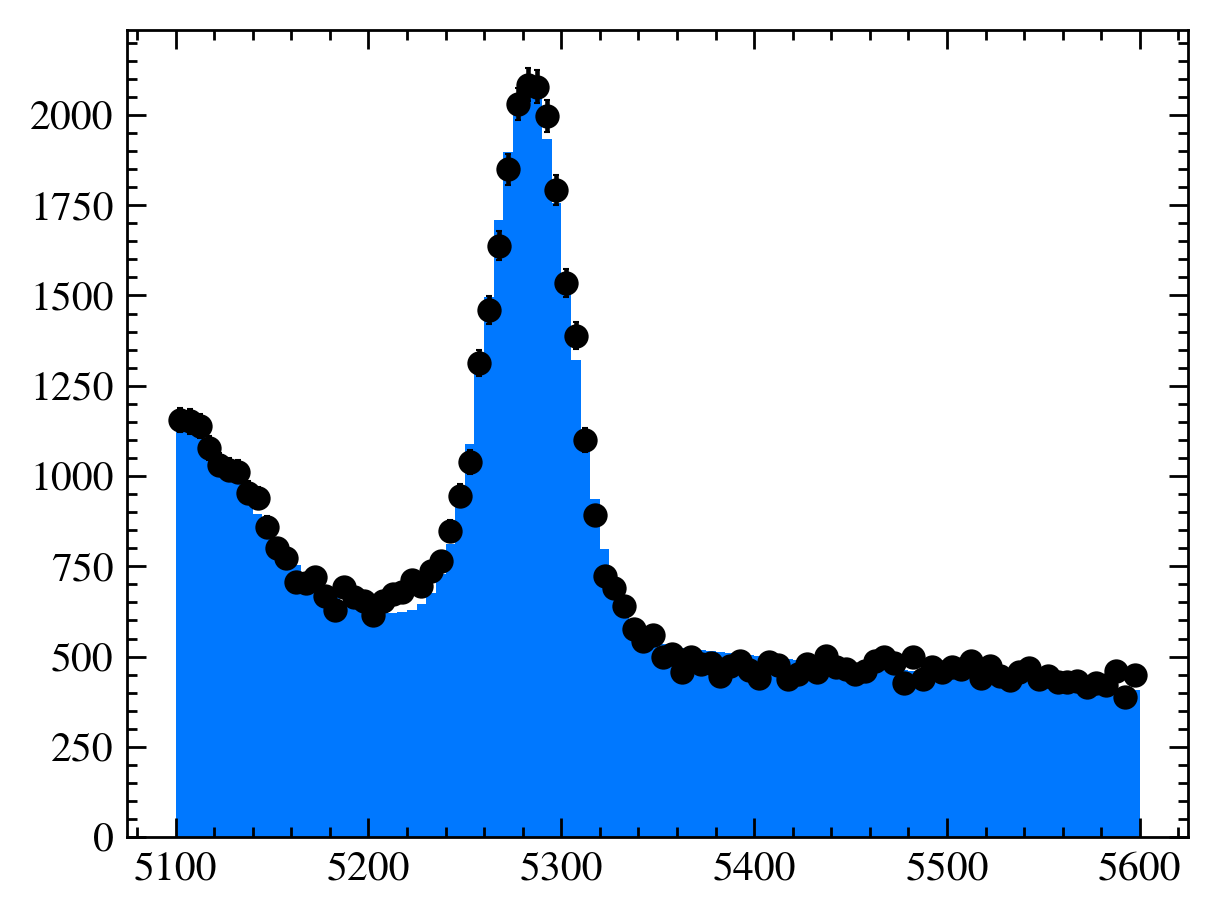

In [30]:
n_plus_gaussian_signal.hesse()

In [154]:
#print the values of the parameters after the fit in a nice way
n_plus_gaussian_signal.values

#parse it to an array
array_of_p0 = np.array([n_plus_gaussian_signal.values["signal_mu"],
                        n_plus_gaussian_signal.values["signal_sigma"],
                        n_plus_gaussian_signal.values["signal_norm"],
                        n_plus_gaussian_signal.values["partial_mu"],
                        n_plus_gaussian_signal.values["partial_sigma"],
                        n_plus_gaussian_signal.values["partial_norm"],
                        n_plus_gaussian_signal.values["tau"],
                        n_plus_gaussian_signal.values["xoffset"],
                        n_plus_gaussian_signal.values["exp_norm"],
                        n_plus_gaussian_signal.values["total_norm"]])


In [155]:
epsilon = 10

lower_array = array_of_p0 - epsilon
upper_array = array_of_p0 + epsilon



In [156]:
#free the normalisation parameter by setting lower_array for it to 0
lower_array[2] = 0
lower_array[5] = 0
lower_array[8] = 0
lower_array[9] = 0

#set the upper limit for the normalisation parameter to 1e4
upper_array[2] = 1e9
upper_array[5] = 1e9
upper_array[8] = 1e9
upper_array[9] = 1e9


/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/minuit.py:2353: IMinuitWarning: Specified nsigma bound, but error matrix is not accurate
  warnings.warn(


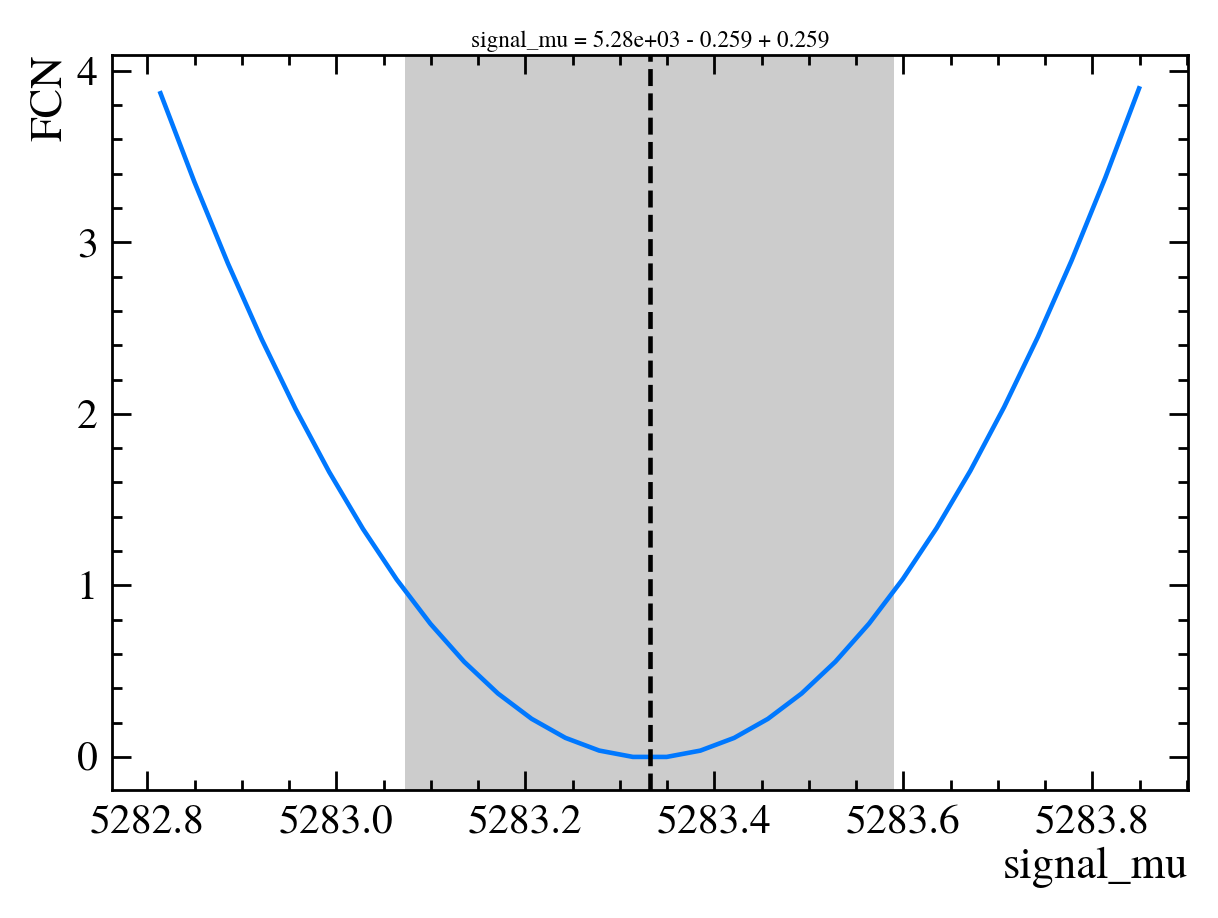

In [157]:
n_plus_gaussian_signal.draw_mnprofile("signal_mu", subtract_min=True);

# Fit the data using curve_fit


In [160]:
def fit_curve_bounds(data, p0_vals, lower_bound, upper_bound):
    hist_raw = plt.hist(data, bins=BINS, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA

    pot, pcov = curve_fit(fit_gaussian, bin_centers, bin_heights, p0=p0_vals, bounds=(lower_bound, upper_bound))
    plt.clf()
    return pot, pcov

    

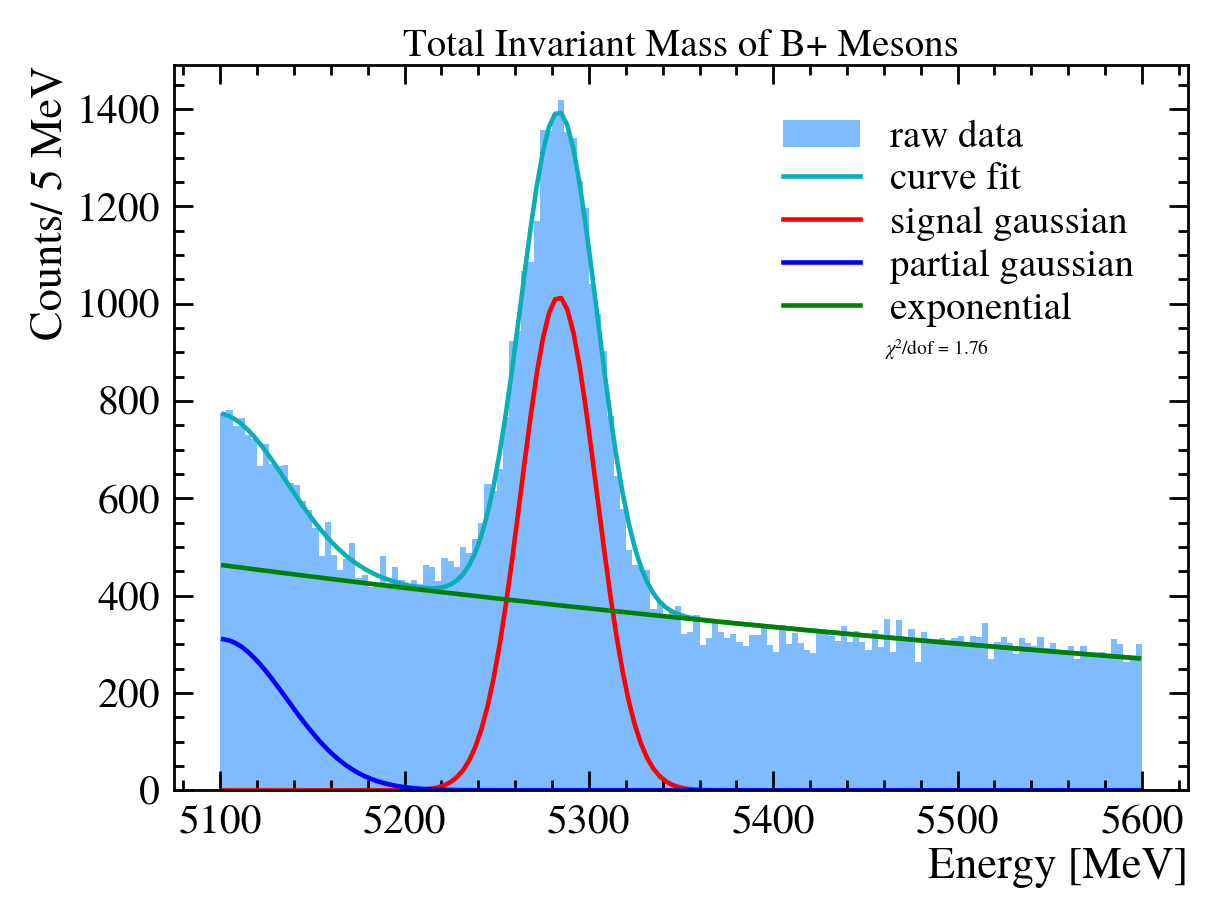

In [161]:
#popt, pcov = fit_gaussian_post_minut(data_plus, array_of_p0)

popt, pcov = fit_curve_bounds(data_plus, array_of_p0, lower_array, upper_array)
#trying with bounds 




#plot the data
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

#calculate the fit
signal_gaussian = norm.pdf(bin_centers, popt[0], popt[1]) * popt[2] * popt[-1]
partial_gaussian = halfnorm.pdf(bin_centers, popt[3], popt[4]) * popt[5] * popt[-1]
exponential = expon.pdf(bin_centers, popt[6], popt[7]) * popt[8] * popt[-1]

total_signal_gausain = signal_gaussian + partial_gaussian + exponential
pure_signal_gaussian = total_signal_gausain - partial_gaussian - exponential


#plot the fit
plt.plot(bin_centers, fit_gaussian(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, signal_gaussian, label="signal gaussian", color="red")
plt.plot(bin_centers, partial_gaussian, label="partial gaussian", color="blue")
plt.plot(bin_centers, exponential, label="exponential", color="green")

#add labels
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_gaussian(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 1
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)

#increase size of text
#add title
plt.title("Total Invariant Mass of B+ Mesons")

plt.legend()


In [37]:
#compute the p-value of the fit
from scipy import stats
p_value = 1 - stats.chi2.cdf(chi_squared, dof)
print("p-value = {:.2f}".format(p_value))


p-value = 0.00


Number of events:  52177.09613541902


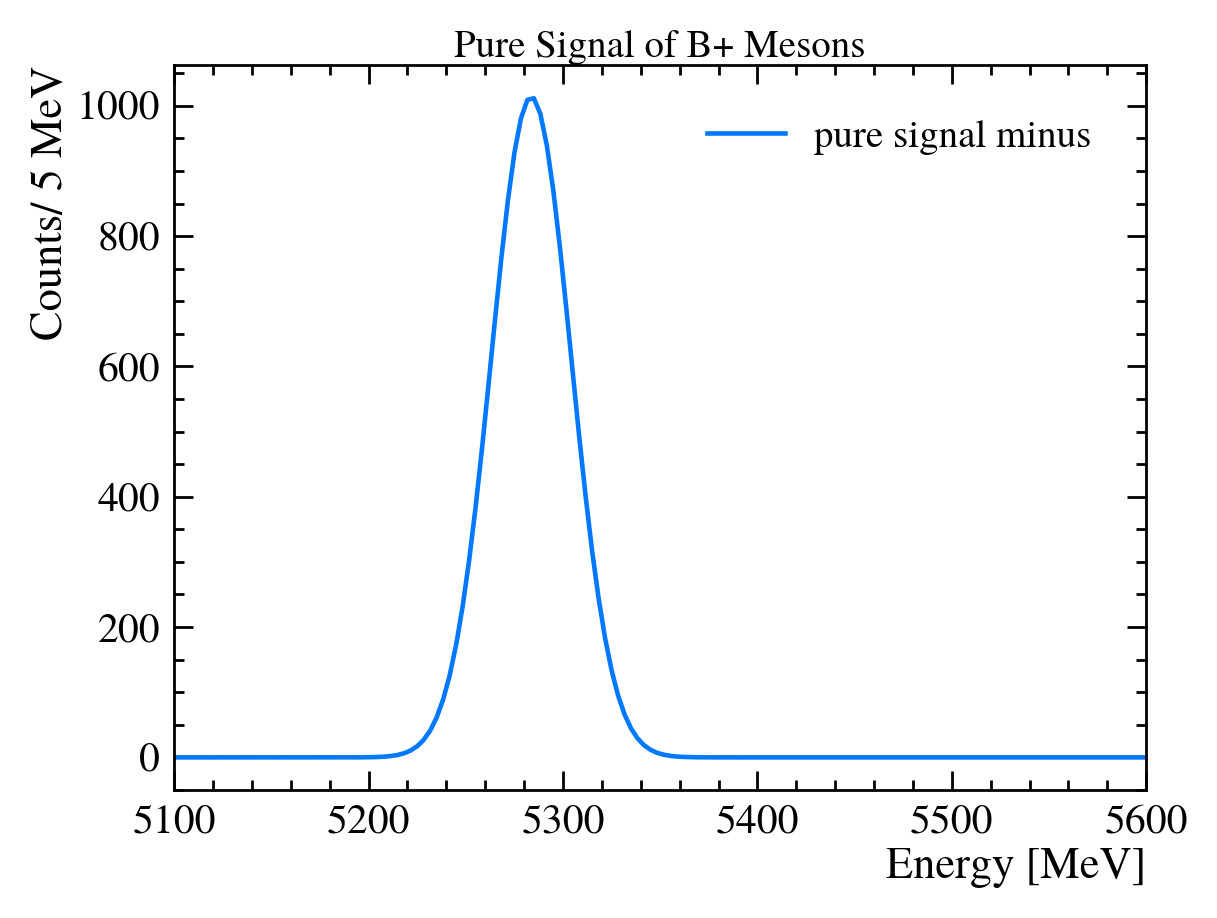

In [162]:
plt.figure()
plt.plot(bin_centers, pure_signal_gaussian, label="pure signal minus")
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")
plt.title("Pure Signal of B+ Mesons")
plt.xlim(5100, 5600)
plt.legend()

#integrate the pure signal to get the number of events
number_of_events_minus = np.trapz(pure_signal_gaussian, bin_centers)
print("Number of events: ", number_of_events_minus)

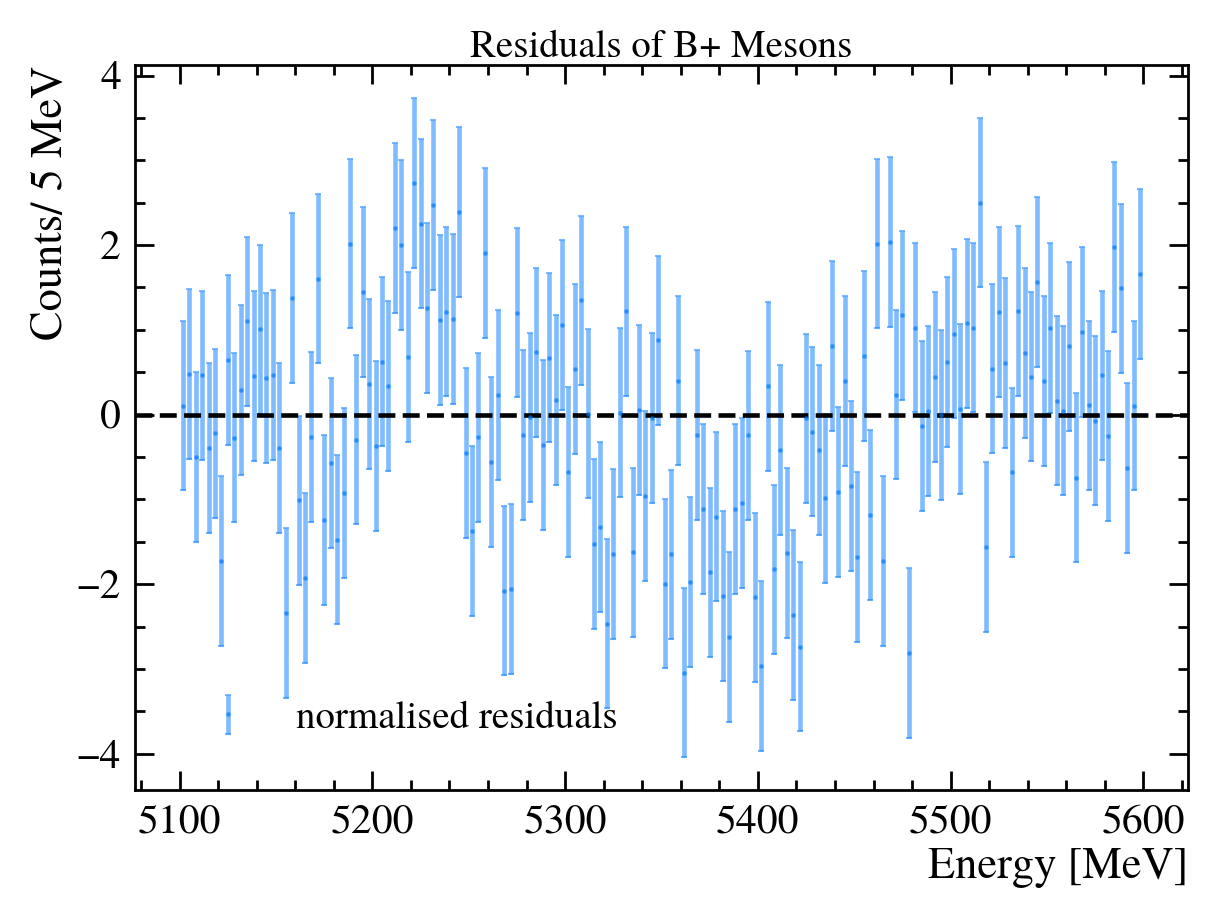

In [163]:
#plot the residuals for the data vs the fitting
plt.figure()
#plot the normalised residuals
plt.errorbar(bin_centers, (bin_heights - fit_gaussian(bin_centers, *popt)) / np.sqrt(bin_heights),
             label="normalised residuals",
             yerr= 1, color="C0", alpha=0.5,
             fmt="o", markersize=2)

#add 

plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")
plt.title("Residuals of B+ Mesons")
#plot a horizontal line at 0
plt.axhline(0, color="black", linestyle="--")
plt.legend()

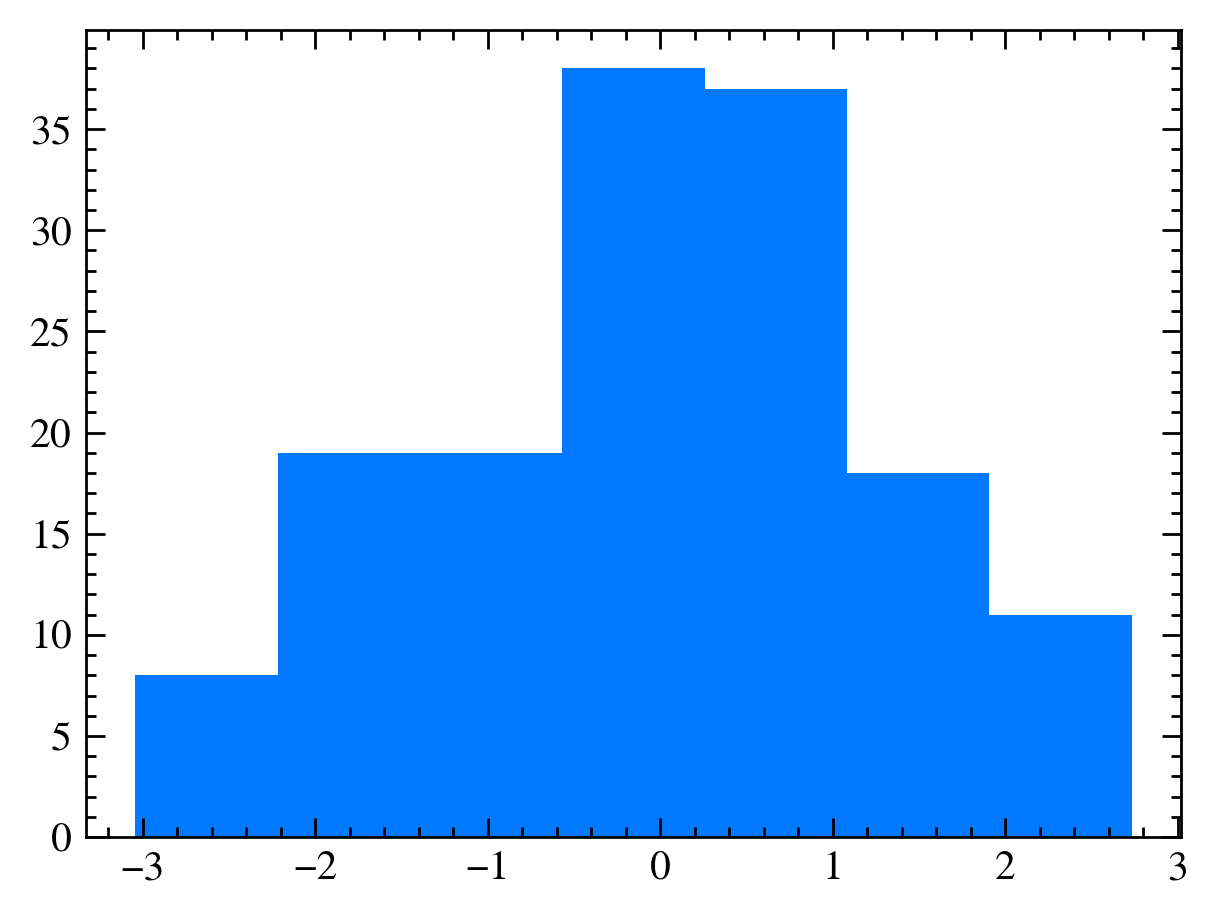

In [164]:
#bin the residuals into 10 bins
residuals, bin_edges, _ = plt.hist((bin_heights - fit_gaussian(bin_centers, *popt)) / np.sqrt(bin_heights), bins=7, label="residuals")


# Usinng Different Background functions

In [165]:
def linear_function(x, a, b):
    return a*x + b

def linear_cdf(x, a, b):
    return (a/2)*x**2 + b * x

In [166]:
def fit_gaussian_lin(x, signal_mu, signal_sigma, signal_norm,
                partial_mu, partial_sigma, partial_norm,
                a, b, lin_norm, 
                total_norm):
    
    signal_gaussian = norm.pdf(x, signal_mu, signal_sigma) * signal_norm
    partial_gaussian = halfnorm.pdf(x, partial_mu, partial_sigma) * partial_norm
    linear = linear_function(x, a, b) * lin_norm
    
    return (signal_gaussian + partial_gaussian + linear) * total_norm

@jit
def minut_gauss_linear(x, signal_mu, signal_sigma, signal_norm,
                    partial_mu, partial_sigma, partial_norm,
                    a, b, lin_norm,
                    total_norm):
    
    signal_gaussian = norm.cdf(x, signal_mu, signal_sigma) * signal_norm
    partial_gaussian = halfnorm.cdf(x, partial_mu, partial_sigma) * partial_norm
    linear = linear_cdf(x, a, b) * lin_norm

    return (signal_gaussian + partial_gaussian + linear) * total_norm

def fit_gaussian_lin_post_minut(data, p0_vals, lower_bound=None, upper_bound=None):
    hist_raw = plt.hist(data, bins=BINS, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA
    
    if lower_bound:
        popt, pcov = curve_fit(fit_gaussian_lin, bin_centers, bin_heights, p0=p0_vals,
                               bounds=(lower_bound, upper_bound))
    else:
        popt, pcov = curve_fit(fit_gaussian_lin, bin_centers, bin_heights, p0=p0_vals)
    plt.clf()
    return popt, pcov

In [167]:
c_gaussian_linear = cost.ExtendedBinnedNLL(n_plus, xe_plus, minut_gauss_linear)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [168]:
n_plus_gauss_linear = Minuit(c_gaussian_linear,
                                signal_mu=5300,
                                signal_sigma=10,
                                signal_norm=1000,

                                partial_mu=5100,
                                partial_sigma=60,
                                partial_norm=700,

                                a = -0.04,
                                b = 400,
                                lin_norm = 0.3,

                                total_norm=10,
)


# n_plus_gauss_linear.limits['signal_sigma'] = (1, 50)
# n_plus_gauss_linear.limits['signal_norm'] = (1, 1e4)
# n_plus_gauss_linear.limits['signal_mu'] = (5200, 5400)

# n_plus_gauss_linear.limits['partial_sigma'] = (1, 50)
# n_plus_gauss_linear.limits['partial_norm'] = (1, 1e4)
n_plus_gauss_linear.limits['partial_mu'] = (5100, 5101)

In [169]:
n_plus_gauss_linear.migrad(iterate=20, ncall=1000000)
n_plus_gauss_linear.interactive()

/tmp/ipykernel_6403/2718003548.py:12: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "minut_gauss_linear" failed type inference due to: Untyped global name 'halfnorm': Cannot determine Numba type of <class 'scipy.stats._continuous_distns.halfnorm_gen'>

File "../../../../tmp/ipykernel_6403/2718003548.py", line 19:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "minut_gauss_linear" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_6403/2718003548.py", line 12:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 261.5 (χ²/ndof = 1.9)      │              Nfcn = 703              │
│ EDM = 4.47e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ signal_mu     │ 5.28319e3 │ 0.00026e3 │            │            │         │         │       │
│ 1 │ signal_sigma  │   20.89   │   0.28    │            │            │         │         │       │
│ 2 │ signal_norm   │  1.59e3   │  0.08e3   │            │            │         │         │       │
│ 3 │ partial_mu    │  5.100e3  │  0.001e3  │            │            │  5100   │  5101   │       │
│ 4 │ partial_sigma │   39.3    │    1.8    │            │            │         │         │       │
│ 5 │ partial_norm  │    490    │    40     │            │            │         │         │       │
│ 6 │ a             │ -42.5e-3  │  0.4e-3   │            │            │         │         │       │
│ 7 │ b             │   273.5   │    2.6    │            │            │         │         │       │
│ 8 │ lin_norm      │   0.230   │   0.012   │            │            │         │         │       │
│ 9 │ total_norm    │   10.0    │    0.5    │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │     signal_mu  signal_sigma   signal_norm    partial_mu partial_sigma  partial_norm             a             b      lin_norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     signal_mu │        0.0675         -0.01         -1.44             0         -0.03         -0.88      -7.03e-6         -0.03       0.26e-3          0.01 │
│  signal_sigma │         -0.01        0.0781          5.82            -0          0.15          3.32      22.11e-6          0.08      -0.89e-3         -0.02 │
│   signal_norm │         -1.44          5.82      6.16e+03      -0.28e-3          38.3         2.3e3    5.07210e-3            36     420.59e-3        -34.40 │
│    partial_mu │             0            -0      -0.28e-3      5.76e-05      -0.06e-3      -1.07e-3            -0      -0.01e-3             0             0 │
│ partial_sigma │         -0.03          0.15          38.3      -0.06e-3          3.23          39.4     205.36e-6           0.8      -7.95e-3         -0.15 │
│  partial_norm │         -0.88          3.32         2.3e3      -1.07e-3          39.4      1.31e+03    4.40691e-3            22      21.14e-3        -12.68 │
│             a │      -7.03e-6      22.11e-6    5.07210e-3            -0     205.36e-6    4.40691e-3       1.9e-07    -799.94e-6      -0.90e-6     -18.99e-6 │
│             b │         -0.03          0.08            36      -0.01e-3           0.8 

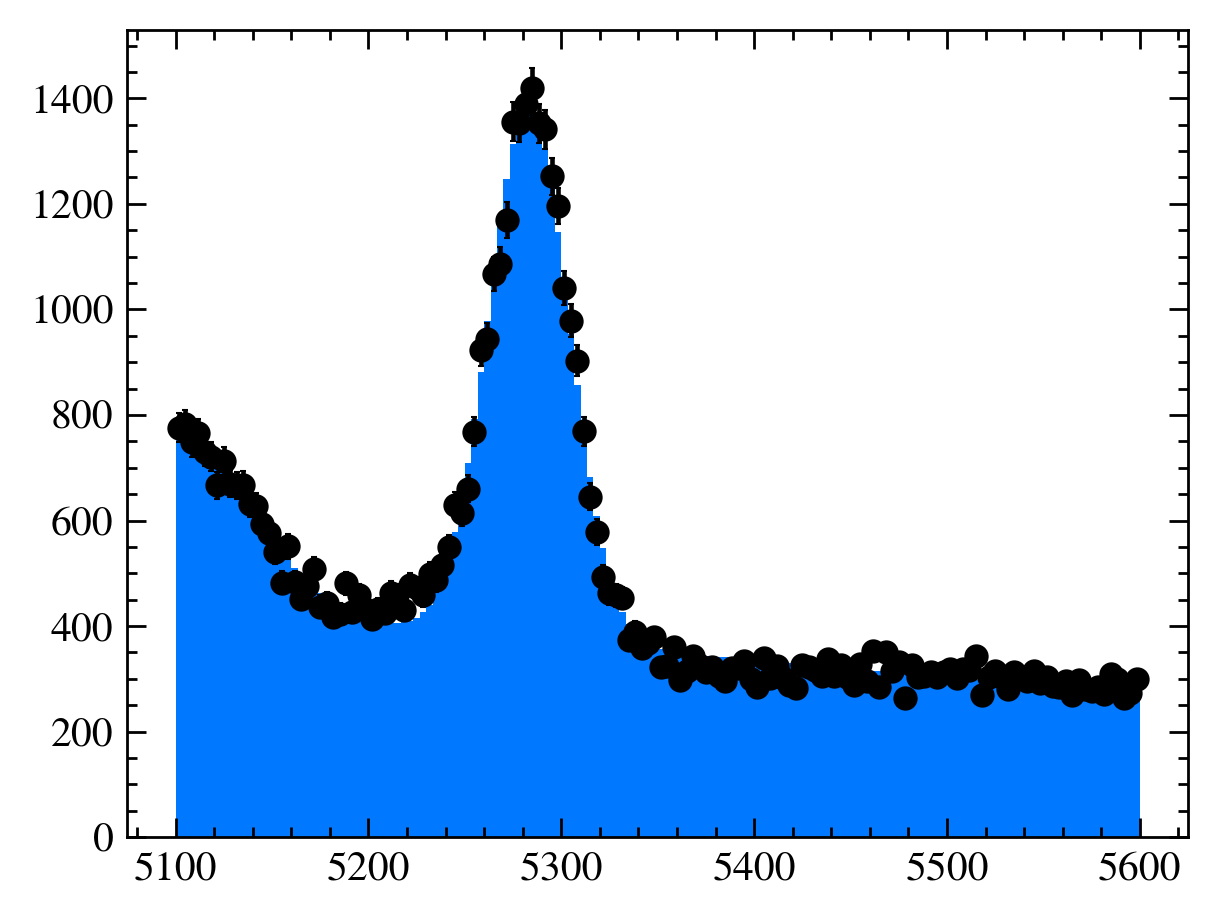

In [170]:
n_plus_gauss_linear.hesse()

In [177]:
array_of_p0_linear_background = np.array([n_plus_gauss_linear.values['signal_mu'],
                                            n_plus_gauss_linear.values['signal_sigma'],                                 
                                            n_plus_gauss_linear.values['signal_norm'],
                                            n_plus_gauss_linear.values['partial_mu'],
                                            n_plus_gauss_linear.values['partial_sigma'],
                                            n_plus_gauss_linear.values['partial_norm'],
                                            n_plus_gauss_linear.values['a'],
                                            n_plus_gauss_linear.values['b'],
                                            n_plus_gauss_linear.values['lin_norm'],
                                            n_plus_gauss_linear.values['total_norm'],
                                            ])

epsilon = 10

lower_array = array_of_p0_linear_background - epsilon
upper_array = array_of_p0_linear_background + epsilon

#set the lower array and upper array bounds for linear function
lower_array[6] = -0.2
upper_array[6] = 0.1

lower_array[2] = 0
upper_array[2] = 1e4

lower_array[5] = 0
upper_array[5] = 1e9


lower_array[7] = 0
upper_array[7] = 1.2e3

lower_array[8] = 0
upper_array[8] = 1e1

lower_array[9] = 0
upper_array[9] = 1e1



In [178]:
array_of_p0_linear_background

array([ 5.28319264e+03,  2.08899945e+01,  1.59237872e+03,  5.10000001e+03,
        3.93196549e+01,  4.89408544e+02, -4.25414569e-02,  2.73467906e+02,
        2.30289638e-01,  9.99799517e+00])

In [179]:
#print array lower and upper bounds in a nice format
for i in range(len(lower_array)):
    #print the lower and upper bounds and the array of p0 in one line
    print("lower bound: ", lower_array[i], "upper bound: ", upper_array[i], "p0: ", array_of_p0_linear_background[i])

lower bound:  5273.192635324324 upper bound:  5293.192635324324 p0:  5283.192635324324
lower bound:  10.889994482699173 upper bound:  30.889994482699173 p0:  20.889994482699173
lower bound:  0.0 upper bound:  10000.0 p0:  1592.3787177483518
lower bound:  5090.000007987647 upper bound:  5110.000007987647 p0:  5100.000007987647
lower bound:  29.31965490857037 upper bound:  49.31965490857037 p0:  39.31965490857037
lower bound:  0.0 upper bound:  1000000000.0 p0:  489.4085441517961
lower bound:  -0.2 upper bound:  0.1 p0:  -0.042541456857447355
lower bound:  0.0 upper bound:  1200.0 p0:  273.4679063249034
lower bound:  0.0 upper bound:  10.0 p0:  0.23028963848359646
lower bound:  0.0 upper bound:  10.0 p0:  9.997995166163374


In [180]:


def fit_curve_bounds(data, p0_vals, lower_bound, upper_bound):
    hist_raw = plt.hist(data, bins=BINS, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA

    popt, pcov = curve_fit(fit_gaussian_lin, bin_centers, bin_heights, p0=p0_vals,
                               bounds=(lower_bound, upper_bound))
    plt.clf()
    return popt, pcov

In [181]:
popt

array([ 5.28396392e+03,  1.86764296e+01,  4.85762881e+03,  5.11169176e+03,
        2.18331342e+01,  6.26515931e+02, -5.16526274e-02,  3.09827953e+02,
        1.24774872e+00,  9.28989450e+00])

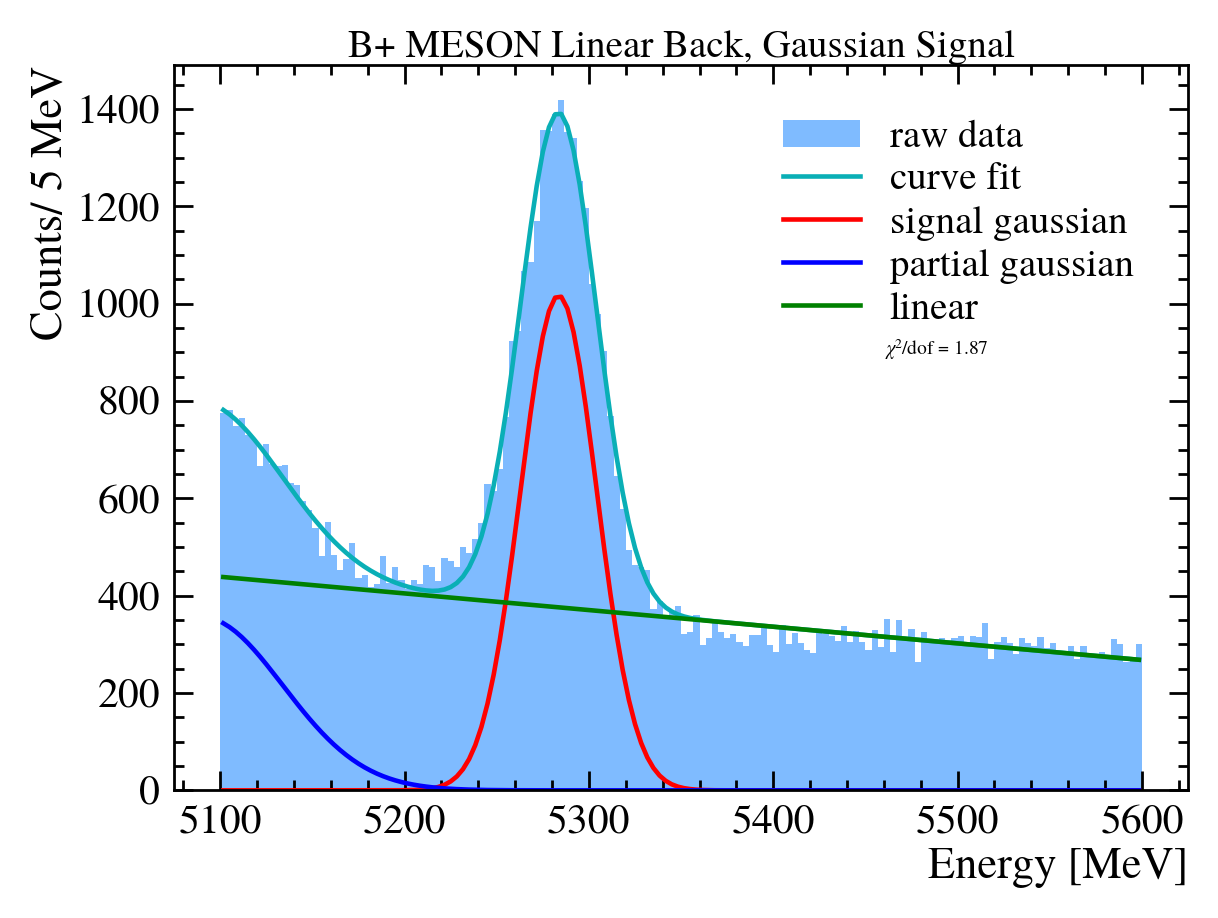

In [182]:

popt, pcov = fit_curve_bounds(data_plus, array_of_p0_linear_background, lower_array, upper_array)
#trying with bounds 



#plot the data
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

#calculate the fit
signal_gaussian = norm.pdf(bin_centers, popt[0], popt[1]) * popt[2] * popt[-1]
partial_gaussian = halfnorm.pdf(bin_centers, popt[3], popt[4]) * popt[5] * popt[-1]
linear = linear_function(bin_centers, popt[6], popt[7]) * popt[-2] * popt[-1]

total_signal_gausain_lin = signal_gaussian + partial_gaussian + linear
pure_signal_gaussian_lin = total_signal_gausain_lin - partial_gaussian - linear


#plot the fit
plt.plot(bin_centers, fit_gaussian_lin(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, signal_gaussian, label="signal gaussian", color="red")
plt.plot(bin_centers, partial_gaussian, label="partial gaussian", color="blue")
plt.plot(bin_centers, linear, label="linear", color="green")

#add labels
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_gaussian_lin(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 1
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)

#increase size of text
#add title
plt.title("B+ MESON Linear Back, Gaussian Signal")

plt.legend()

Number of events:  52663.62686250949


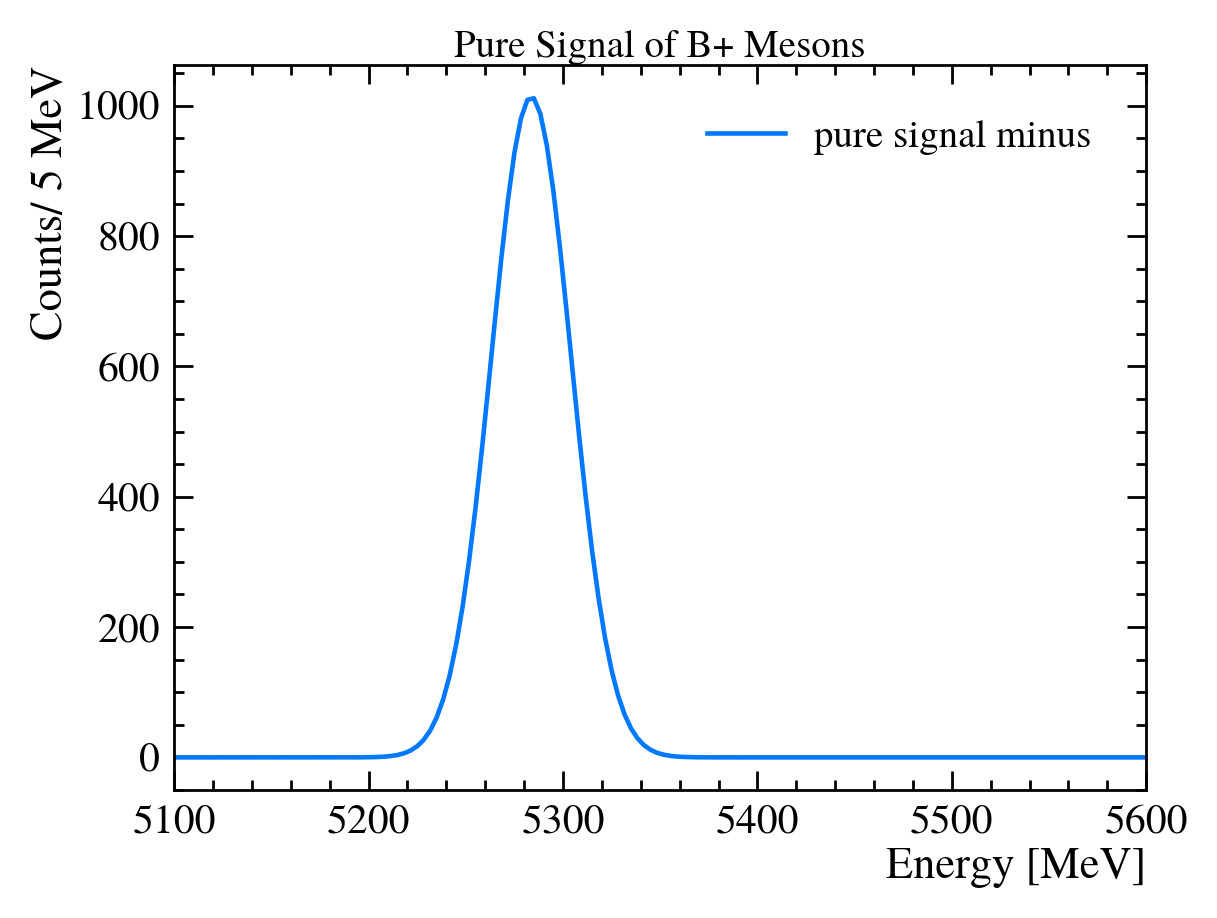

In [183]:
plt.figure()
plt.plot(bin_centers, pure_signal_gaussian, label="pure signal minus")
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")
plt.title("Pure Signal of B+ Mesons")
plt.xlim(5100, 5600)
plt.legend()

#integrate the pure signal to get the number of events
number_of_events_lin = np.trapz(pure_signal_gaussian_lin, bin_centers)
print("Number of events: ", number_of_events_lin)

# LINEAR WITH CRYSTALBALL

In [90]:
def cdf_crystal_linear(x, 
                       crystal_beta, crystal_m, crystal_loc, crystal_scale,
                       partial_mu, partial_sigma, partial_norm,
                       a, b, lin_norm,
                       total_norm):
    
    #calculate the crystal ball function
    crystal_ball = crystalball.cdf(x, crystal_beta, crystal_m, crystal_loc, crystal_scale) * total_norm
    partial_gaussian = halfnorm.cdf(x, partial_mu, partial_sigma) * partial_norm * total_norm
    linear = linear_function(x, a, b) * lin_norm * total_norm

    return crystal_ball + partial_gaussian + linear

@jit 
def minut_cball_linear(x, 
                       crystal_beta, crystal_m, crystal_loc, crystal_scale,
                       crystal_norm,
                       partial_mu, partial_sigma, partial_norm,
                       a, b, lin_norm,
                       total_norm):
    signal_crystal = crystalball.pdf(x, crystal_beta, crystal_m, crystal_loc, crystal_scale) * total_norm * crystal_norm
    partial_gaussian = halfnorm.pdf(x, partial_mu, partial_sigma) * partial_norm * total_norm
    linear = linear_function(x, a, b) * lin_norm * total_norm

    return signal_crystal + partial_gaussian + linear

def fit_crystal_lin_post_minut(data, p0_vals, lower_bound=None,
                               upper_bound=None):
    hist_raw = plt.hist(data, bins=BINS, label="raw data", color="C0", alpha=0.5)
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heights = hist_raw[0]
    #SET A BOUND ON THE SIGMA
    if lower_bound:
        popt, pcov = curve_fit(minut_cball_linear, bin_centers, bin_heights, p0=p0_vals,
                               bounds=(lower_bound, upper_bound))
    else:
        popt, pcov = curve_fit(minut_cball_linear, bin_centers, bin_heights, p0=p0_vals)
    plt.clf()
    return popt, pcov

In [91]:
c_crystal_lin = cost.ExtendedBinnedNLL(n_plus, xe_plus, minut_cball_linear)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [94]:
n_cball_linear = Minuit(c_crystal_lin,
                       crystal_beta=1.2, crystal_m=5,
                        crystal_loc=5366.3,
                          crystal_scale=5.29,
                          crystal_norm=1000,
                       partial_mu=5100, partial_sigma=10, partial_norm=1000,
                       a=0, b=0, lin_norm=1000,
                       total_norm=100)

n_cball_linear.limits['partial_mu'] = (5099, 5101)
n_cball_linear.limits['partial_sigma'] = (0, 100)
n_cball_linear.limits['partial_norm'] = (0, 10000)
n_cball_linear.limits['crystal_beta'] = (0, 100)
n_cball_linear.limits['crystal_m'] = (0, 20)
n_cball_linear.limits['crystal_loc'] = (5200, 5467)



In [95]:
n_cball_linear.migrad(iterate=20, ncall=10000004)
n_cball_linear.interactive()

# Final Result